In [3]:
import sys
sys.path.append('/home/dmoi/projects/foldtree2')
#read the afdb clusters file
import pandas as pd
import numpy as np
import glob
import os
#autoreload
import pickle
from src import AFDB_tools
import toytree
import tqdm
from matplotlib import pyplot as plt

In [3]:
datadir = '/home/dmoi/datasets/'


In [8]:
#read the afdb rep file
reps = pd.read_table( datadir + 'afdbclusters/1-AFDBClusters-entryId_repId_taxId.tsv', header=None, names=['entryId', 'repId', 'taxId'] )
print( 'reps' , reps.head() )

reps       entryId       repId    taxId
0  A0A009E921  A0A009E921  1310605
1  A0A009F5K6  A0A009E921  1310605
2  A0A009E9H3  A0A009E9H3  1310605
3  A0A484ZLT0  A0A009E9H3    82979
4  A0A009ECR5  A0A009ECR5  1310605


In [14]:
os.makedirs( datadir + 'afdbclusters/structfams/', exist_ok=True )


In [25]:
import pandas as pd
import numpy as np
import random
#eliminate the reps with less than 10 entries
rep = []
for r in reps.repId.unique():
    if len(reps[ reps.repId == r ]) > 10:
        rep.append( r)
    if len( rep ) > 100:
        break
#save the reps


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101


FileNotFoundError: [Errno 2] No such file or directory: '/home/dmoi/datasets/afdbclusters/structfams/100reps.pkl'

In [26]:
with open( datadir + 'afdbclusters/100reps.pkl', 'wb' ) as f:
    pickle.dump( rep, f )

In [22]:
import shutil
clear_files = False
if clear_files:
    shutil.rmtree( datadir + 'afdbclusters/structfams/' )

In [ ]:
import tqdm
for r in tqdm.tqdm(rep):
    sub = reps[ reps.repId == r ]
    print( 'sub', sub )
    os.makedirs( datadir + 'afdbclusters/structfams/' + str(r), exist_ok=True )
    os.makedirs( datadir + 'afdbclusters/structfams/' + str(r) + '/structs/', exist_ok=True )
    sub= sub.sample(min(10,len(sub)))
    for uniID in sub.entryId:
        print( 'uniID', uniID )
        AFDB_tools.grab_struct(uniID , structfolder= datadir + 'afdbclusters/structfams/' + str(r) + '/structs/')
    print( 'structs', os.listdir( datadir + 'afdbclusters/structfams/' + str(r) + '/structs/') )
foldmason.fasta.nw

In [ ]:
#save the repstructs dataframe
repstructs.to_csv( datadir + 'afdbclusters/repstructs.tsv', sep='\t', index=False )

In [3]:
import sys
import os
sys.path.append('/home/dmoi/projects/fold_tree/src')

import corecut
import numpy as np
import pandas as pd
import foldseek2tree

def structblob2tree(input_folder, outfolder, overwrite = False,
             fastmepath = 'fastme', quicktreepath = 'quicktree' , 
         foldseekpath = 'foldseek' , delta = 0.0001 ,
       correction = False , kernel = 'fident' , core = False 
       , hittresh = .8 , minthresh = .6 , swapids = False):
    '''
    run fold tree pipeline for a folder of pdb files
    
    Parameters
    ----------
    input_folder : str
        path to folder with pdb files   
    outfolder : str
        path to output folder   
    overwrite : bool
        overwrite existing foldseek output  
    fastmepath : str    
        path to fastme executable
    quicktreepath : str 
        path to quicktree executable
    foldseekpath : str  
        path to foldseek executable 
    delta : float   
        small number to replace negative branch lengths with, default is .0001
    correction : str    
        correction method to use, either 'tajima' or 'none'
    kernel : str    
        kernel to use, either 'fident', 'lddt' or 'alntmscore'
    
    '''
    #check if the foldseek output is already there
    if os.path.exists(outfolder + 'res.m8') and overwrite == False:
        print('found foldseek output, skipping foldseek')
        alnres = outfolder + 'res.m8'
    else:
        alnres = foldseek2tree.runFoldseek_allvall_EZsearch(input_folder , outfolder + 'res.m8', foldseekpath = foldseekpath)
    
    if core == True:

        corecut.extract_core( alnres , alnres+'.core.csv',  hitthresh = .8 ,minthresh = .6, structfolder= input_folder.split('/')[-2]+'/' , corefolder = input_folder+'core_structs/'  )
        if os.path.exists(outfolder + 'res.m8') and overwrite == False:
            print('found foldseek core output, skipping foldseek')
            alnres = outfolder + 'core.res.m8'
        else:
            alnres = foldseek2tree.runFoldseek_allvall_EZsearch(input_folder , outfolder + 'core.res.m8', foldseekpath = foldseekpath)
    
    
    res = pd.read_table(alnres , header = None )
    res[0] = res[0].map(lambda x :x.replace('.pdb', ''))
    res[1] = res[1].map(lambda x :x.replace('.pdb', ''))
    res.columns = 'query,target,fident,alnlen,mismatch,gapopen,qstart,qend,tstart,tend,evalue,bits,lddt,lddtfull,alntmscore'.split(',')
    ids = sorted(list( set(list(res['query'].unique()) + list(res['target'].unique()))))
    if swapids:
        res['numerical_query'] = res['query'].map(lambda x : ids.index(x))
        res['numerical_target'] = res['target'].map(lambda x : ids.index(x))
    
    pos = { protid : i for i,protid in enumerate(ids)}
    if swapids:
        ids = [ str(i) for i in range(len(ids))]

    matrices = { kernel:np.zeros((len(pos), len(pos)))  }
    print(res)

    #calc kernel for tm, aln score, lddt
    for idx,row in res.iterrows():
        for k in matrices:
            matrices[k][pos[row['query']] , pos[row['target']]] += row[k]
            matrices[k][pos[row['target']] , pos[row['query']]] += row[k]
    trees = {}
    for i,k in enumerate(matrices):
        matrices[k] /= 2
        matrices[k] = 1-matrices[k]
        matrices[k] = np.clip(matrices[k], 0, 1)
        
        print(matrices[k], np.amax(matrices[k]), np.amin(matrices[k]) )
        if correction:
            if kernel == 'fident':
                factor = .93
            else:
                factor = 1
            matrices[k] = foldseek2tree.Tajima_dist(matrices[k], bfactor = factor)
        np.save( input_folder + k + '_distmat.npy' , matrices[k])
        distmat_txt = foldseek2tree.distmat_to_txt( ids , matrices[k] , outfolder + k + '_distmat.txt' )
        out_tree = foldseek2tree.runFastme(  fastmepath = fastmepath , clusterfile = distmat_txt )
        out_tree = foldseek2tree.postprocess(out_tree, input_folder + 'structblob_tree.nwk' , delta = delta)
        trees[k] = out_tree
    return alnres, trees

In [ ]:
import subprocess
import shlex

def run_foldmason(structdir, output_dir):
    #run foldmason
    cmd = 'foldmason easy-msa {0} {1}foldmason.fasta {2}foldmasontmp '.format(structdir, output_dir , output_dir)
    print(cmd)
    subprocess.run(shlex.split(cmd))
    return output_dir + 'foldmason.fasta'

def prepare_family(input_folder, outfolder):

    #run foldmason
    foldmason_aln = run_foldmason(input_folder, outfolder)
    #run foldtree
    alnres, trees = structblob2tree(input_folder, outfolder, overwrite = False,
                fastmepath = 'fastme', quicktreepath = 'quicktree' , 
            foldseekpath = 'foldseek' , delta = 0.0001 ,
        correction = False , kernel = 'fident' , core = False 
        , hittresh = .8 , minthresh = .6)
    return foldmason_aln, outfolder + 'fidentfoldtree.nwk'

for fam in tqdm.tqdm(glob.glob(datadir +'afdbclusters/structfams/*/')):
    print(fam)
    prepare_family(fam+'structs/' , fam + '/' )

In [27]:
import pickle
import sys
sys.path.append('/home/dmoi/projects/foldtree2')

encoder_save = 'encoder_lowcost_final'
decoder_save = 'decoder_lowcost_final'
datadir = '/home/dmoi/datasets/'
model_dir = '/home/dmoi/projects/foldtree2/models/'

import foldtree2_ecddcd as ft2
import torch
inputchars = """0 1 2 3 4 5 6 7 8 9 A B C D E F G H I J K L M N O P Q R S T U V W X Y Z ! " # $ % & ' ( ) * + , / : ; < = > @ [ \ ] ^ _ { | } ~""".split()

ndim = 844
converter = ft2.PDB2PyG(aapropcsv='/home/dmoi/projects/foldtree2/aaindex1.csv')
#switch device to cpu

with open( model_dir + encoder_save + 'proto_model.pkl' , 'rb' ) as f:
    encoder,decoder = pickle.load( f )




alphabetsize = encoder.vector_quantizer.embedding_dim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
encoder = encoder.to(device)
encoder.eval()



HeteroGAE_Encoder(
  (convs): ModuleList(
    (0): ModuleDict(
      (res_backbone_res): MFConv(844, 400)
      (res_backbonerev_res): MFConv(400, 400)
      (res_contactPoints_res): MFConv(400, 400)
      (res_hbond_res): MFConv(400, 400)
    )
    (1-2): 2 x ModuleDict(
      (res_backbone_res): MFConv(400, 400)
      (res_backbonerev_res): MFConv(400, 400)
      (res_contactPoints_res): MFConv(400, 400)
      (res_hbond_res): MFConv(400, 400)
    )
  )
  (bn): BatchNorm1d(844, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.001, inplace=False)
  (out_dense): Sequential(
    (0): Linear(420, 200, bias=True)
    (1): SiLU()
    (2): Linear(200, 200, bias=True)
    (3): SiLU()
    (4): Linear(200, 200, bias=True)
    (5): SiLU()
    (6): Linear(200, 200, bias=True)
    (7): SiLU()
    (8): Linear(200, 200, bias=True)
    (9): SiLU()
    (10): Linear(200, 200, bias=True)
    (11): SiLU()
    (12): Linear(200, 200, bias=True)
    (13): SiLU()
    

In [28]:
import tqdm
import glob

def loader( structlist , converter):
    for struct in tqdm.tqdm(structlist):
        try:
            data = converter.struct2pyg( struct )
            if data:
                yield data
        except:
            print('error')
            continue

for fam in tqdm.tqdm(glob.glob(datadir +'afdbclusters/structfams/*/')):
    print(fam)
    structs = glob.glob(fam + 'structs/*.pdb')
    l = loader( structs , converter )
    encoder.encode_structures_fasta( l , fam + 'encoded.fasta' , alphabet = inputchars  )


  0%|                                                                                         | 0/101 [00:00<?, ?it/s]

/home/dmoi/datasets/afdbclusters/structfams/A0A011N458/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.24it/s]
10it [00:02,  4.23it/s]
  1%|▊                                                                                | 1/101 [00:02<03:56,  2.37s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A009NI06/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.14it/s]
10it [00:01,  7.12it/s]
  2%|█▌                                                                               | 2/101 [00:03<02:58,  1.81s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010RA97/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.14s/it]
10it [00:21,  2.14s/it]
  3%|██▍                                                                              | 3/101 [00:25<17:34, 10.76s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A011P9Q6/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.76it/s]
10it [00:02,  3.75it/s]
  4%|███▏                                                                             | 4/101 [00:27<12:14,  7.57s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010RDZ2/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.87s/it]
10it [00:18,  1.87s/it]
  5%|████                                                                             | 5/101 [00:46<18:32, 11.59s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010QV66/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.97it/s]
10it [00:02,  3.96it/s]
  6%|████▊                                                                            | 6/101 [00:49<13:28,  8.51s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A009LLL0/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.09it/s]
10it [00:02,  4.08it/s]
  7%|█████▌                                                                           | 7/101 [00:51<10:13,  6.53s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A009QF58/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.19it/s]
10it [00:01,  5.18it/s]
  8%|██████▍                                                                          | 8/101 [00:53<07:51,  5.07s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A009ECR5/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.45it/s]
10it [00:06,  1.45it/s]
  9%|███████▏                                                                         | 9/101 [01:00<08:38,  5.64s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A011M8L1/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.21it/s]
10it [00:08,  1.21it/s]
 10%|███████▉                                                                        | 10/101 [01:08<09:47,  6.45s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010QBH7/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.80s/it]
10it [00:17,  1.80s/it]
 11%|████████▋                                                                       | 11/101 [01:26<14:58,  9.98s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010RFX4/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.20it/s]
10it [00:02,  4.20it/s]
 12%|█████████▌                                                                      | 12/101 [01:29<11:22,  7.67s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010QH57/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.16it/s]
10it [00:04,  2.15it/s]
 13%|██████████▎                                                                     | 13/101 [01:33<09:54,  6.76s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A009I5S8/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  9.33it/s]
10it [00:01,  9.30it/s]
 14%|███████████                                                                     | 14/101 [01:34<07:18,  5.04s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A009QKS2/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.27it/s]
10it [00:01,  7.26it/s]
 15%|███████████▉                                                                    | 15/101 [01:36<05:38,  3.94s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A009Q7Y6/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.70it/s]
10it [00:01,  6.68it/s]
 16%|████████████▋                                                                   | 16/101 [01:37<04:32,  3.21s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010QIB6/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.48it/s]
10it [00:06,  1.48it/s]
 17%|█████████████▍                                                                  | 17/101 [01:44<05:58,  4.27s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A009J8A1/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.65it/s]
10it [00:02,  3.64it/s]
 18%|██████████████▎                                                                 | 18/101 [01:47<05:16,  3.82s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010Z6J6/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.74it/s]
10it [00:03,  2.74it/s]
 19%|███████████████                                                                 | 19/101 [01:50<05:09,  3.77s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A009LG02/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.75it/s]
10it [00:05,  1.75it/s]
 20%|███████████████▊                                                                | 20/101 [01:56<05:52,  4.35s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010ZQ01/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.73it/s]
10it [00:02,  3.72it/s]
 21%|████████████████▋                                                               | 21/101 [01:59<05:08,  3.86s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A009LHJ9/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.45it/s]
10it [00:02,  3.45it/s]
 22%|█████████████████▍                                                              | 22/101 [02:02<04:42,  3.57s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010QTJ4/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.15it/s]
10it [00:08,  1.15it/s]
 23%|██████████████████▏                                                             | 23/101 [02:10<06:39,  5.12s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010Q4R4/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.13it/s]
10it [00:08,  1.13it/s]
 24%|███████████████████                                                             | 24/101 [02:19<08:01,  6.25s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A009ZZM7/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.77it/s]
10it [00:03,  2.76it/s]
 25%|███████████████████▊                                                            | 25/101 [02:23<06:55,  5.46s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A011MY18/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  7.53it/s]
10it [00:01,  7.51it/s]
 26%|████████████████████▌                                                           | 26/101 [02:24<05:16,  4.23s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010Q175/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.24it/s]
10it [00:03,  3.23it/s]
 27%|█████████████████████▍                                                          | 27/101 [02:27<04:47,  3.89s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010SDI4/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.38it/s]
10it [00:04,  2.38it/s]
 28%|██████████████████████▏                                                         | 28/101 [02:32<04:51,  3.99s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010Q0U6/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.91it/s]
10it [00:05,  1.91it/s]
 29%|██████████████████████▉                                                         | 29/101 [02:37<05:14,  4.36s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A009JM56/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.61it/s]
10it [00:03,  2.61it/s]
 30%|███████████████████████▊                                                        | 30/101 [02:41<04:58,  4.21s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010RCJ1/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.47it/s]
10it [00:06,  1.47it/s]
 31%|████████████████████████▌                                                       | 31/101 [02:47<05:48,  4.99s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010ZM43/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.27it/s]
10it [00:04,  2.27it/s]
 32%|█████████████████████████▎                                                      | 32/101 [02:52<05:32,  4.81s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010R9P6/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.14it/s]
10it [00:03,  3.13it/s]
 33%|██████████████████████████▏                                                     | 33/101 [02:55<04:54,  4.33s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010R299/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.94it/s]
10it [00:03,  2.93it/s]
 34%|██████████████████████████▉                                                     | 34/101 [02:59<04:31,  4.06s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010S131/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:28<00:00,  2.87s/it]
10it [00:28,  2.87s/it]
 35%|███████████████████████████▋                                                    | 35/101 [03:27<12:35, 11.45s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A009K3J7/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.38it/s]
10it [00:02,  3.37it/s]
 36%|████████████████████████████▌                                                   | 36/101 [03:30<09:39,  8.91s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A009PU45/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.09it/s]
10it [00:02,  4.09it/s]
 37%|█████████████████████████████▎                                                  | 37/101 [03:33<07:26,  6.97s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010Q311/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.24it/s]
10it [00:08,  1.23it/s]
 38%|██████████████████████████████                                                  | 38/101 [03:41<07:40,  7.31s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A009EYT8/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.92it/s]
10it [00:05,  1.92it/s]
 39%|██████████████████████████████▉                                                 | 39/101 [03:46<06:54,  6.69s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010SSY2/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.41it/s]
10it [00:04,  2.40it/s]
 40%|███████████████████████████████▋                                                | 40/101 [03:50<06:01,  5.93s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010R5R1/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.06it/s]
10it [00:09,  1.06it/s]
 41%|████████████████████████████████▍                                               | 41/101 [04:00<06:59,  6.99s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A011NB92/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.18it/s]
10it [00:01,  5.17it/s]
 42%|█████████████████████████████████▎                                              | 42/101 [04:02<05:22,  5.47s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A011M2B8/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.11it/s]
10it [00:01,  5.09it/s]
 43%|██████████████████████████████████                                              | 43/101 [04:04<04:16,  4.42s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010JSD3/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.17it/s]
10it [00:04,  2.17it/s]
 44%|██████████████████████████████████▊                                             | 44/101 [04:08<04:15,  4.48s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010RFJ8/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.17it/s]
10it [00:02,  4.16it/s]
 45%|███████████████████████████████████▋                                            | 45/101 [04:11<03:36,  3.86s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010YDU6/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.19it/s]
10it [00:04,  2.19it/s]
 46%|████████████████████████████████████▍                                           | 46/101 [04:15<03:44,  4.08s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010TBK8/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.57it/s]
10it [00:03,  2.57it/s]
 47%|█████████████████████████████████████▏                                          | 47/101 [04:19<03:37,  4.03s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A011MIK5/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.63it/s]
10it [00:02,  3.63it/s]
 48%|██████████████████████████████████████                                          | 48/101 [04:22<03:13,  3.65s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A011NVJ3/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.54it/s]
10it [00:06,  1.54it/s]
 49%|██████████████████████████████████████▊                                         | 49/101 [04:28<03:54,  4.50s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A011MH15/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.86it/s]
10it [00:02,  3.85it/s]
 50%|███████████████████████████████████████▌                                        | 50/101 [04:31<03:20,  3.93s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A011P9P5/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.49s/it]
10it [00:14,  1.49s/it]
 50%|████████████████████████████████████████▍                                       | 51/101 [04:46<06:01,  7.22s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010RZH3/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.29it/s]
10it [00:07,  1.29it/s]
 51%|█████████████████████████████████████████▏                                      | 52/101 [04:54<06:01,  7.38s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010PZP1/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.43it/s]
10it [00:04,  2.42it/s]
 52%|█████████████████████████████████████████▉                                      | 53/101 [04:58<05:07,  6.40s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010PTL2/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.79it/s]
10it [00:02,  3.78it/s]
 53%|██████████████████████████████████████████▊                                     | 54/101 [05:00<04:08,  5.28s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A011NHP0/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.67it/s]
10it [00:03,  2.66it/s]
 54%|███████████████████████████████████████████▌                                    | 55/101 [05:04<03:41,  4.83s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A011NP66/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.17s/it]
10it [00:11,  1.17s/it]
 55%|████████████████████████████████████████████▎                                   | 56/101 [05:16<05:09,  6.88s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010YHB2/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.19it/s]
10it [00:02,  4.19it/s]
 56%|█████████████████████████████████████████████▏                                  | 57/101 [05:18<04:03,  5.53s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010YC68/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.17it/s]
10it [00:08,  1.17it/s]
 57%|█████████████████████████████████████████████▉                                  | 58/101 [05:27<04:36,  6.43s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010RTK1/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.46s/it]
10it [00:24,  2.46s/it]
 58%|██████████████████████████████████████████████▋                                 | 59/101 [05:51<08:19, 11.89s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A011NVJ4/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.65it/s]
10it [00:02,  3.64it/s]
 59%|███████████████████████████████████████████████▌                                | 60/101 [05:54<06:15,  9.15s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010QYK0/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.14it/s]
10it [00:08,  1.14it/s]
 60%|████████████████████████████████████████████████▎                               | 61/101 [06:03<06:01,  9.04s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010SM59/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:21<00:00,  2.12s/it]
10it [00:21,  2.12s/it]
 61%|█████████████████████████████████████████████████                               | 62/101 [06:24<08:14, 12.68s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A011P8I0/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.55it/s]
10it [00:06,  1.55it/s]
 62%|█████████████████████████████████████████████████▉                              | 63/101 [06:30<06:51, 10.82s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010R0N5/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.20s/it]
10it [00:11,  1.20s/it]
 63%|██████████████████████████████████████████████████▋                             | 64/101 [06:43<06:53, 11.18s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A011NXL4/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.90it/s]
10it [00:02,  4.89it/s]
 64%|███████████████████████████████████████████████████▍                            | 65/101 [06:45<05:03,  8.44s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010QA35/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]
10it [00:16,  1.64s/it]
 65%|████████████████████████████████████████████████████▎                           | 66/101 [07:01<06:18, 10.82s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010Z4N9/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.43it/s]
10it [00:04,  2.43it/s]
 66%|█████████████████████████████████████████████████████                           | 67/101 [07:05<04:59,  8.81s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010QIQ0/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.88it/s]
10it [00:02,  3.87it/s]
 67%|█████████████████████████████████████████████████████▊                          | 68/101 [07:08<03:49,  6.95s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010YLN3/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.57it/s]
10it [00:03,  2.57it/s]
 68%|██████████████████████████████████████████████████████▋                         | 69/101 [07:12<03:13,  6.03s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010YC40/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.84s/it]
10it [00:18,  1.84s/it]
 69%|███████████████████████████████████████████████████████▍                        | 70/101 [07:30<05:01,  9.74s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A011NWD8/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.29it/s]
10it [00:02,  4.28it/s]
 70%|████████████████████████████████████████████████████████▏                       | 71/101 [07:32<03:45,  7.52s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A009LJR2/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.68it/s]
10it [00:05,  1.68it/s]
 71%|█████████████████████████████████████████████████████████                       | 72/101 [07:38<03:24,  7.05s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A011MY67/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.34it/s]
10it [00:02,  3.34it/s]
 72%|█████████████████████████████████████████████████████████▊                      | 73/101 [07:41<02:43,  5.84s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010QCV1/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.80it/s]
10it [00:05,  1.80it/s]
 73%|██████████████████████████████████████████████████████████▌                     | 74/101 [07:47<02:35,  5.76s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A011P594/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.92it/s]
10it [00:01,  6.90it/s]
 74%|███████████████████████████████████████████████████████████▍                    | 75/101 [07:48<01:56,  4.47s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010QQ59/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.50it/s]
10it [00:04,  2.49it/s]
 75%|████████████████████████████████████████████████████████████▏                   | 76/101 [07:52<01:48,  4.33s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A009R020/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.97it/s]
10it [00:02,  4.96it/s]
 76%|████████████████████████████████████████████████████████████▉                   | 77/101 [07:54<01:27,  3.64s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010R0R5/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.83it/s]
10it [00:05,  1.83it/s]
 77%|█████████████████████████████████████████████████████████████▊                  | 78/101 [08:00<01:36,  4.19s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A011NTR6/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.32s/it]
10it [00:13,  1.32s/it]
 78%|██████████████████████████████████████████████████████████████▌                 | 79/101 [08:13<02:31,  6.90s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A009G5I8/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.46it/s]
10it [00:02,  3.46it/s]
 79%|███████████████████████████████████████████████████████████████▎                | 80/101 [08:16<01:59,  5.70s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010QS06/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:13<00:00,  1.38s/it]
10it [00:13,  1.38s/it]
 80%|████████████████████████████████████████████████████████████████▏               | 81/101 [08:30<02:42,  8.14s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010ZNN6/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.40it/s]
10it [00:01,  5.39it/s]
 81%|████████████████████████████████████████████████████████████████▉               | 82/101 [08:32<01:58,  6.25s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A009LPV9/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.18it/s]
10it [00:08,  1.18it/s]
 82%|█████████████████████████████████████████████████████████████████▋              | 83/101 [08:40<02:04,  6.93s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A009HSJ6/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.45s/it]
10it [00:14,  1.45s/it]
 83%|██████████████████████████████████████████████████████████████████▌             | 84/101 [08:55<02:36,  9.20s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A011NXV5/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.62it/s]
10it [00:06,  1.61it/s]
 84%|███████████████████████████████████████████████████████████████████▎            | 85/101 [09:01<02:12,  8.30s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010SK14/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.95it/s]
10it [00:02,  3.95it/s]
 85%|████████████████████████████████████████████████████████████████████            | 86/101 [09:03<01:38,  6.57s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A011NYK9/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.24it/s]
10it [00:03,  3.24it/s]
 86%|████████████████████████████████████████████████████████████████████▉           | 87/101 [09:06<01:17,  5.53s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010QHB0/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.26it/s]
10it [00:07,  1.26it/s]
 87%|█████████████████████████████████████████████████████████████████████▋          | 88/101 [09:14<01:21,  6.26s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010RC88/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.01it/s]
10it [00:04,  2.01it/s]
 88%|██████████████████████████████████████████████████████████████████████▍         | 89/101 [09:19<01:10,  5.88s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A009KPD8/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.62it/s]
10it [00:02,  4.61it/s]
 89%|███████████████████████████████████████████████████████████████████████▎        | 90/101 [09:22<00:52,  4.77s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A011MVW2/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.51it/s]
10it [00:01,  8.49it/s]
 90%|████████████████████████████████████████████████████████████████████████        | 91/101 [09:23<00:36,  3.69s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010Q600/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.41it/s]
10it [00:04,  2.41it/s]
 91%|████████████████████████████████████████████████████████████████████████▊       | 92/101 [09:27<00:34,  3.83s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010RJK7/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.53it/s]
10it [00:06,  1.53it/s]
 92%|█████████████████████████████████████████████████████████████████████████▋      | 93/101 [09:34<00:37,  4.65s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A009YGQ6/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.60it/s]
10it [00:03,  2.60it/s]
 93%|██████████████████████████████████████████████████████████████████████████▍     | 94/101 [09:37<00:30,  4.41s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010KCF6/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.36it/s]
10it [00:02,  3.36it/s]
 94%|███████████████████████████████████████████████████████████████████████████▏    | 95/101 [09:40<00:23,  3.99s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010R113/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.10it/s]
10it [00:09,  1.10it/s]
 95%|████████████████████████████████████████████████████████████████████████████    | 96/101 [09:49<00:27,  5.51s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A009JY85/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.63it/s]
10it [00:06,  1.63it/s]
 96%|████████████████████████████████████████████████████████████████████████████▊   | 97/101 [09:56<00:22,  5.70s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A011NF35/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  6.18it/s]
10it [00:01,  6.16it/s]
 97%|█████████████████████████████████████████████████████████████████████████████▌  | 98/101 [09:57<00:13,  4.48s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A009EYQ5/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.23it/s]
10it [00:01,  5.22it/s]
 98%|██████████████████████████████████████████████████████████████████████████████▍ | 99/101 [09:59<00:07,  3.71s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A011P8J1/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.08it/s]
10it [00:04,  2.07it/s]
 99%|██████████████████████████████████████████████████████████████████████████████▏| 100/101 [10:04<00:04,  4.05s/it]

/home/dmoi/datasets/afdbclusters/structfams/A0A010R7U6/
using alphabet
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '/', ':', ';', '<', '=', '>', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']













100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.27it/s]
10it [00:03,  3.26it/s]
100%|███████████████████████████████████████████████████████████████████████████████| 101/101 [10:07<00:00,  6.02s/it]


{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, 'A': 10, 'B': 11, 'C': 12, 'D': 13, 'E': 14, 'F': 15, 'G': 16, 'H': 17, 'I': 18, 'J': 19, 'K': 20, 'L': 21, 'M': 22, 'N': 23, 'O': 24, 'P': 25, 'Q': 26, 'R': 27, 'S': 28, 'T': 29, 'U': 30, 'V': 31, 'W': 32, 'X': 33, 'Y': 34, 'Z': 35, '!': 36, '"': 37, '#': 38, '$': 39, '%': 40, '&': 41, "'": 42, '(': 43, ')': 44, '*': 45, '+': 46, ',': 47, '/': 48, ':': 49, ';': 50, '<': 51, '=': 52, '>': 53, '@': 54, '[': 55, '\\': 56, ']': 57, '^': 58, '_': 59, '{': 60, '|': 61, '}': 62, '~': 63}


100%|██████████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 493.10it/s]


[0.01536237 0.01474811 0.05517937 0.00386812 0.03011048 0.01401215
 0.00985139 0.00921395 0.05657015 0.03053641 0.00816506 0.00505029
 0.02272773 0.0037725  0.00809842 0.01645472 0.01525517 0.00517198
 0.02234237 0.00879381 0.01502337 0.01025703 0.0163649  0.00747547
 0.00673661 0.05413338 0.01610992 0.0363806  0.01095822 0.00963118
 0.0057225  0.01827143 0.01288793 0.02672334 0.00452584 0.0372904
 0.0037696  0.00502131 0.00795355 0.01378615 0.00660043 0.00758267
 0.01081625 0.02294504 0.01037293 0.00197028 0.03560408 0.00267146
 0.05824489 0.00966305 0.00317273 0.00751024 0.00745229 0.01074671
 0.00481559 0.00500103 0.01126246 0.03347444 0.00645266 0.01546089
 0.019216   0.00917918 0.0191088  0.00636863]


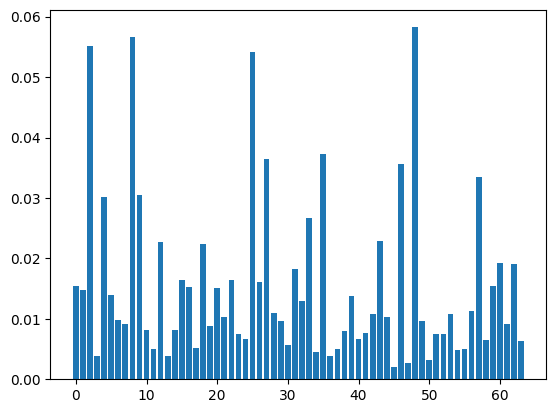

In [52]:
#char frequences
import numpy as np
from matplotlib import pyplot as plt
indices = { c:i for i,c in enumerate(inputchars) }

print(indices)
charfreqs = np.zeros((len(inputchars)))
for fam in tqdm.tqdm(glob.glob(datadir +'afdbclusters/structfams/*/')):
    fasta = fam + 'encoded.fasta'
    with open( fasta , 'r') as f:
        for l in f:
            for c in l.strip():
                charfreqs[indices[c]]+=1
charfreqs = charfreqs / charfreqs.sum()
print(charfreqs)
plt.bar( range(len(inputchars)), charfreqs)

#save the charfreqs
with open( datadir + 'afdbclusters/charfreqs.pkl' , 'wb') as f:
    pickle.dump( charfreqs , f)

#save as text

with open( datadir + 'afdbclusters/charfreqs.txt' , 'w') as f:
    for i,c in enumerate(inputchars):
        f.write( c + '\t' + str(charfreqs[i]) + '\n')
